In [ ]:
pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import open3d as o3d
import copy
import numpy as np
# Load the Knot mesh
knot = o3d.data.KnotMesh()
mesh = o3d.io.read_triangle_mesh(knot.path)

# Compute vertex normals
mesh.compute_vertex_normals()



[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/KnotMesh.ply
[Open3D INFO] Downloaded to /root/open3d_data/download/KnotMesh/KnotMesh.ply


TriangleMesh with 1440 points and 2880 triangles.

#icp


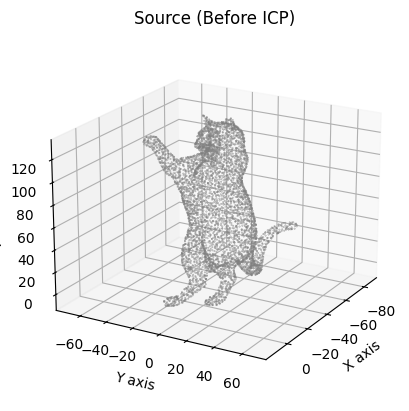

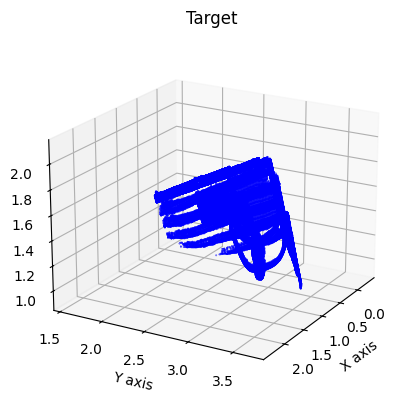

Iteration 1:
  Rotation Angle (degrees): 100.27
  Translation: [-5.36217017  0.39574807  5.12080157]
  Error Margin (MSE): 55.9035


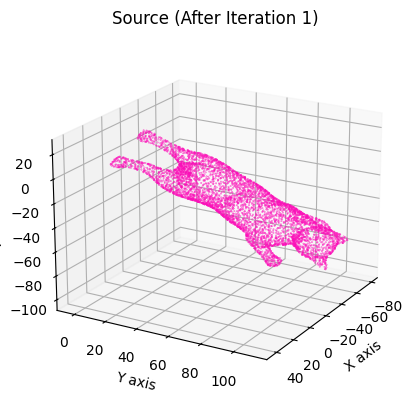

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


<ipython-input-6-7f99611a1817>:97: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((np.trace(R) - 1) / 2)


Iteration 2:
  Rotation Angle (degrees): nan
  Translation: [-1.55592517  4.88772454  0.52343622]
  Error Margin (MSE): 27.2320


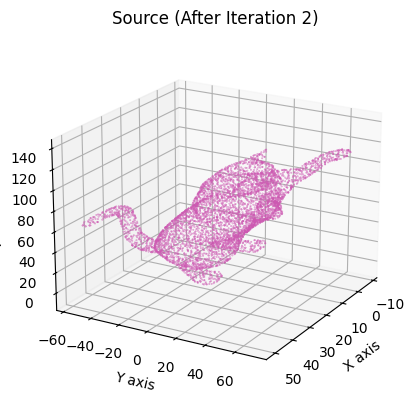

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


KeyboardInterrupt: 

In [ ]:
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt

# Load the mesh and convert to point cloud
mesh = o3d.io.read_triangle_mesh('/content/cat1_un4.obj')
source = mesh.sample_points_uniformly(number_of_points=5000)  # Converting to point cloud with 5000 points
target = o3d.io.read_point_cloud(o3d.data.DemoICPPointClouds().paths[1])

# Function to apply rotation to target
def rotate_target(target, angle_deg, axis=(0, 0, 1)):
    R = target.get_rotation_matrix_from_axis_angle(np.radians(angle_deg) * np.array(axis))
    target.rotate(R, center=(0, 0, 0))

# Function to plot point cloud with a single color
# Function to plot point cloud with a single color and clearer visualization
def plot_point_cloud(point_cloud, title, color=(0, 0, 0)):
    points = np.asarray(point_cloud.points)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with reduced marker size and added axis labels for clarity
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, color=[color], alpha=0.8)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Adjust view angle for better visibility
    ax.view_init(elev=20, azim=30)  # Adjust elevation and azimuth for a better angle
    plt.show()

# Function to draw registration result with Open3D
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp], zoom=0.4459, front=[0.9288, -0.2951, -0.2242], lookat=[1.6784, 2.0612, 1.4451], up=[-0.3402, -0.9189, -0.1996])

# Function to find nearest neighbors
def find_nearest_neighbors(source_pc, target_pc, nearest_neigh_num=1):
    point_cloud_tree = o3d.geometry.KDTreeFlann(source_pc)
    points_arr = []
    for point in target_pc.points:
        [_, idx, _] = point_cloud_tree.search_knn_vector_3d(point, nearest_neigh_num)
        points_arr.append(source_pc.points[idx[0]])
    return np.asarray(points_arr)

# ICP algorithm with angle, translation, and error margin display
def icp(source, target):
    source.paint_uniform_color([0.5, 0.5, 0.5])
    target.paint_uniform_color([0, 0, 1])
    target_points = np.asarray(target.points)

    transform_matrix = np.asarray([[0.862, 0.011, -0.507, 0.5], [-0.139, 0.967, -0.215, 0.7], [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
    source = source.transform(transform_matrix)

    curr_iteration = 0
    cost_change_threshold = 0.001
    curr_cost = 1000
    prev_cost = 10000

    # Plot initial points
    plot_point_cloud(source, "Source (Before ICP)", color='grey')
    plot_point_cloud(target, "Target", color='blue')

    while True:
        new_source_points = find_nearest_neighbors(source, target)
        # Centroids and relative positions
        source_centroid = np.mean(new_source_points, axis=0)
        target_centroid = np.mean(target_points, axis=0)
        source_repos = new_source_points - source_centroid
        target_repos = target_points - target_centroid

        # Compute SVD for rotation and translation
        cov_mat = target_repos.T @ source_repos
        U, _, Vt = np.linalg.svd(cov_mat)
        R = U @ Vt
        t = target_centroid - R @ source_centroid

        # Calculate the error margin (MSE) for the current iteration
        aligned_source_points = (R @ source_repos.T).T + t
        error_margin = np.mean(np.linalg.norm(target_repos - aligned_source_points, axis=1)**2)

        curr_cost = np.linalg.norm(target_repos - (R @ source_repos.T).T)

        if prev_cost - curr_cost > cost_change_threshold:
            prev_cost = curr_cost
            transform_matrix = np.vstack((np.hstack((R, t.reshape(3, 1))), np.array([0, 0, 0, 1])))
            source = source.transform(transform_matrix)
            curr_iteration += 1

            # Calculate rotation angle
            angle = np.arccos((np.trace(R) - 1) / 2)
            angle_deg = np.degrees(angle)
            print(f"Iteration {curr_iteration}:")
            print(f"  Rotation Angle (degrees): {angle_deg:.2f}")
            print(f"  Translation: {t}")
            print(f"  Error Margin (MSE): {error_margin:.4f}")

            # Generate a random color for the plot and plot with the current iteration number
            random_color = tuple(np.random.rand(3))
            plot_point_cloud(source, f"Source (After Iteration {curr_iteration})", color=random_color)
            draw_registration_result(source, target, transform_matrix)
        else:
            break

    print("\nFinal Iteration =", curr_iteration)
    print("Final Transformation Matrix:\n", transform_matrix)

    return transform_matrix

# Rotate target by an initial angle, e.g., 30 degrees around the z-axis
rotate_target(target, angle_deg=30, axis=(0, 0, 1))

# Run ICP
final_transform = icp(source, target)